<a href="https://colab.research.google.com/github/niikkkhiil/niikkkhiil/blob/main/Ayna_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -q wandb

# Import essential libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import wandb
wandb.login()  # You’ll be prompted to enter your API key


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jigneshdoha (jigneshdoha-not-applicable) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Download and extract dataset from Google Drive
!gdown "https://drive.google.com/uc?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM" -O dataset.zip



Downloading...
From: https://drive.google.com/uc?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM
To: /content/dataset.zip
100% 57.8k/57.8k [00:00<00:00, 77.3MB/s]
replace dataset/dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/__MACOSX/dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/__MACOSX/dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ya
replace dataset/dataset/training/data.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
!unzip -q dataset.zip -d dataset

replace dataset/dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [26]:
# Color map (basic 10 color names → RGB)
COLOR_MAP = {
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 0, 255),
    "yellow": (255, 255, 0),
    "purple": (128, 0, 128),
    "orange": (255, 165, 0),
    "pink": (255, 192, 203),
    "black": (0, 0, 0),
    "white": (255, 255, 255),
    "cyan": (0, 255, 255),
    "magenta": (255, 0, 255) # Added magenta
}

In [17]:
class PolygonColorDataset(Dataset):
    def __init__(self, data_json, input_dir, output_dir, transform=None):
        with open(data_json, 'r') as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_path = os.path.join(self.input_dir, item['input'])
        output_path = os.path.join(self.output_dir, item['output'])

        input_image = Image.open(input_path).convert('L')  # Grayscale
        output_image = Image.open(output_path).convert('RGB')  # Colored

        # Get color condition
        color_rgb = torch.tensor(COLOR_MAP[item['color']], dtype=torch.float32) / 255.0
        color_tensor = color_rgb.view(3, 1, 1).expand(3, 64, 64)  # Broadcast to match input size

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        # Concatenate grayscale image (1x64x64) with color tensor (3x64x64)
        input_tensor = torch.cat([input_image, color_tensor], dim=0)  # 4x64x64

        return input_tensor, output_image


In [18]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = PolygonColorDataset(
    data_json='dataset/dataset/training/data.json',
    input_dir='dataset/dataset/training/inputs',
    output_dir='dataset/dataset/training/outputs',
    transform=transform
)

val_dataset = PolygonColorDataset(
    data_json='dataset/dataset/validation/data.json',
    input_dir='dataset/dataset/validation/inputs',
    output_dir='dataset/dataset/validation/outputs',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [19]:
# UNet Block: Convolution -> BatchNorm -> ReLU (twice)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [20]:
# Full UNet Model
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()

        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))  # RGB output in [0,1] range


In [21]:
# Test model output shape
model = UNet().to("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1, 4, 64, 64).to("cuda" if torch.cuda.is_available() else "cpu")
output = model(dummy_input)
print("Output shape:", output.shape)  # Expected: [1, 3, 64, 64]


Output shape: torch.Size([1, 3, 64, 64])


In [22]:
wandb.init(
    project="ayna-color-filler",
    config={
        "epochs": 10,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "loss": "L1Loss",
        "optimizer": "Adam"
    }
)


In [23]:
def train(model, train_loader, val_loader, device, epochs=10):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        wandb.log({"Train Loss": avg_train_loss, "epoch": epoch + 1})

        # Validation
        model.eval()
        val_loss = 0.0
        example_images = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                # Log first 2 sample predictions per epoch
                for i in range(min(2, inputs.size(0))):
                    inp_gray = inputs[i, 0].cpu().numpy()
                    pred_img = outputs[i].cpu().permute(1, 2, 0).numpy()
                    true_img = targets[i].cpu().permute(1, 2, 0).numpy()

                    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
                    ax[0].imshow(inp_gray, cmap='gray')
                    ax[0].set_title("Input Polygon")
                    ax[1].imshow(pred_img)
                    ax[1].set_title("Prediction")
                    ax[2].imshow(true_img)
                    ax[2].set_title("Ground Truth")
                    for a in ax:
                        a.axis('off')
                    wandb.log({f"Sample {i}": wandb.Image(fig)})
                    plt.close(fig)

        avg_val_loss = val_loss / len(val_loader.dataset)
        wandb.log({"Val Loss": avg_val_loss})


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

train(model, train_loader, val_loader, device, epochs=10)


Epoch 10/10: 100%|██████████| 2/2 [00:15<00:00,  7.85s/it]


In [28]:
import json

# Load and inspect the structure of the data.json file
with open('dataset/dataset/training/data.json', 'r') as f:
    sample_data = json.load(f)

# Print the keys of the first item to understand the structure
if sample_data:
    print("Keys in the first item of data.json:", sample_data[0].keys())
else:
    print("data.json is empty or could not be loaded.")

Keys in the first item of data.json: dict_keys(['input_polygon', 'colour', 'output_image'])


In [29]:
torch.save(model.state_dict(), "unet_color_filler.pth")


In [30]:
def predict(model, polygon_img_path, color_name, transform, device):
    model.eval()
    img = Image.open(polygon_img_path).convert('L')
    img_tensor = transform(img)

    # Convert color name to tensor
    color_rgb = torch.tensor(COLOR_MAP[color_name], dtype=torch.float32) / 255.0
    color_tensor = color_rgb.view(3, 1, 1).expand(3, 64, 64)

    # Stack grayscale + color
    input_tensor = torch.cat([img_tensor, color_tensor], dim=0).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)[0].cpu()

    return img_tensor[0], output


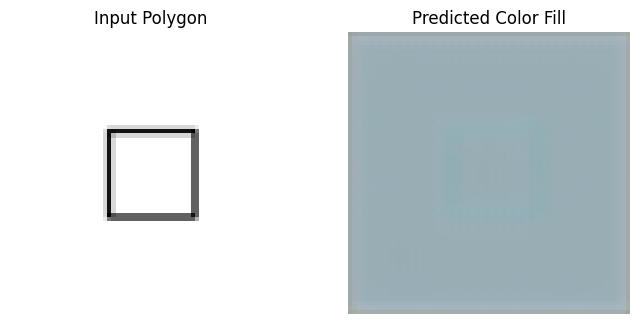

In [34]:
# Load trained model
model = UNet().to(device)
model.load_state_dict(torch.load("unet_color_filler.pth", map_location=device))

# Try prediction
gray, prediction = predict(
    model=model,
    polygon_img_path="dataset/dataset/validation/inputs/square.png",  # Using 'square.png' as it exists
    color_name="blue",
    transform=transform,
    device=device
)

# Show results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title("Input Polygon")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction.permute(1, 2, 0).numpy())
plt.title("Predicted Color Fill")
plt.axis('off')
plt.show()

In [35]:
import os

# List files in the validation inputs directory
validation_input_dir = 'dataset/dataset/validation/inputs'
if os.path.exists(validation_input_dir):
    print(f"Files in {validation_input_dir}:")
    for filename in os.listdir(validation_input_dir):
        print(filename)
else:
    print(f"Directory not found: {validation_input_dir}")

Files in dataset/dataset/validation/inputs:
square.png
octagon.png
star.png
triangle.png
